### CONFIGURATION

In [ ]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
from cellpose import models, io
from glob import glob
import config

# --- CONFIGURATION ---
# 1. Path to your 4x images
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")

CACHE_PATH = os.path.join(config.DATASPACE, "cellpose_cache")
os.makedirs(CACHE_PATH, exist_ok=True)
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = CACHE_PATH

# 2. Now import cellpose (It will see the variable and use the new path)
from cellpose import models, io

print(f"Cellpose will save models to: {os.environ['CELLPOSE_LOCAL_MODELS_PATH']}")

# 2. Pick a Core to test (Change "Core_01" to any core you want to check)
TEST_CORE = "Core_16" 
CK_INDEX = 6  # The Cytokeratin channel index

# 3. TUNING PARAMETERS (The knobs you want to turn)
# 'cyto2' is usually best for cytoplasm/tissue sheets. 
# 'nuclei' is for nuclei.
MODEL_TYPE = 'cyto2' 

# APPROX GLAND SIZE (in pixels). 
# If mask is too small (shattered), INCREASE this.
# If mask merges two distinct glands, DECREASE this.
DIAMETER = 30 

# CONFIDENCE THRESHOLD (0.4 is standard. Lower = more sensitive, Higher = stricter)
FLOW_THRESHOLD = 0.4

Cellpose will save models to: /data3/junming/3D-TMA-Register/cellpose_cache


### 1. Load the Image

Loading: /data3/junming/3D-TMA-Register/downsampled_4x/Core_16/240919_3D_BL_TMA_1_Core16.ome.tif
Image Shape: (1512, 1512)
Data Type: uint16 (Max Value: 647)


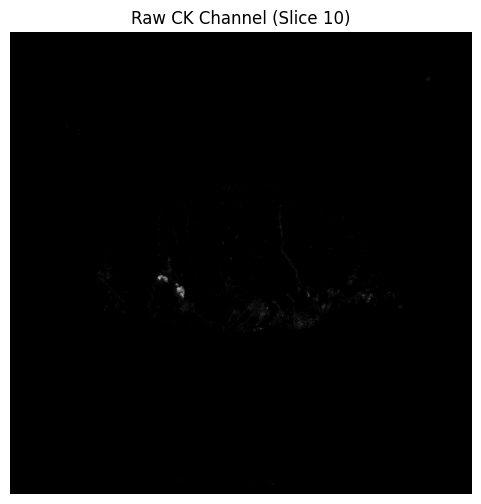

In [21]:
# Find the middle slice of the test core
core_folder = os.path.join(INPUT_ROOT, TEST_CORE)
slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))

if not slice_files:
    print(f"Error: No images found in {core_folder}")
else:
    # Pick middle slice
    mid_idx = len(slice_files) // 2
    test_file = slice_files[mid_idx]
    print(f"Loading: {test_file}")

    # Load
    img = tifffile.imread(test_file)
    
    # Extract CK Channel
    if img.shape[0] < 20: 
        ck = img[CK_INDEX, :, :]
    else: 
        ck = img[:, :, CK_INDEX]
    
    print(f"Image Shape: {ck.shape}")
    print(f"Data Type: {ck.dtype} (Max Value: {ck.max()})")

    # Normalize for display
    ck_vis = cv2.normalize(ck, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(ck_vis, cmap='gray')
    plt.title(f"Raw CK Channel (Slice {mid_idx})")
    plt.axis('off')
    plt.show()

### 2. Run Cellpose Inference

In [22]:
print(f"Initializing Cellpose model: {MODEL_TYPE}...")
# Use CellposeModel directly
model = models.CellposeModel(gpu=True, model_type=MODEL_TYPE)

print(f"Running Inference (Diameter={DIAMETER})...")

# FIX: Unpack only 3 values (masks, flows, styles)
masks, flows, styles = model.eval(
    ck, 
    diameter=DIAMETER, 
    channels=[0,0], 
    flow_threshold=FLOW_THRESHOLD
)

print(f"Done. Found {len(np.unique(masks)) - 1} regions.")

model_type argument is not used in v4.0.1+. Ignoring this argument...


Initializing Cellpose model: cyto2...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Running Inference (Diameter=30)...
Done. Found 15 regions.


### 3. Visualize Prediction

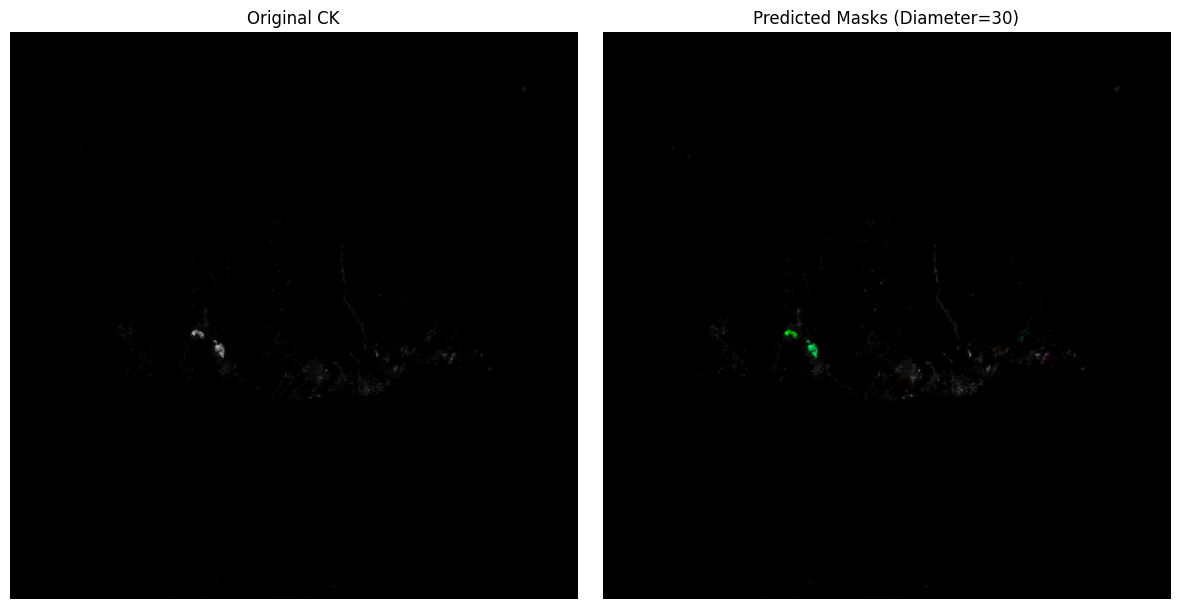

In [23]:
from cellpose import plot

fig = plt.figure(figsize=(12, 6))

# Plot Original
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(ck_vis, cmap='gray')
ax1.set_title("Original CK")
ax1.axis('off')

# Plot Masks
# Cellpose has a helper to create random colors for masks
mask_overlay = plot.mask_overlay(ck_vis, masks)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(mask_overlay)
ax2.set_title(f"Predicted Masks (Diameter={DIAMETER})")
ax2.axis('off')

plt.tight_layout()
plt.show()

### 4. Filter for "Stable" Regions

Stable Regions Found:
  Region 1: Area=498 px, Centroid=(946, 578)
  Region 2: Area=552 px, Centroid=(964, 693)
  Region 3: Area=906 px, Centroid=(1167, 805)
  Region 4: Area=725 px, Centroid=(499, 806)
  Region 5: Area=492 px, Centroid=(1119, 806)
  Region 6: Area=1132 px, Centroid=(555, 847)
  Region 7: Area=815 px, Centroid=(1185, 879)
  Region 8: Area=530 px, Centroid=(1062, 896)
  Region 9: Area=1375 px, Centroid=(767, 931)
  Region 10: Area=1010 px, Centroid=(730, 938)
  Region 11: Area=1492 px, Centroid=(793, 944)


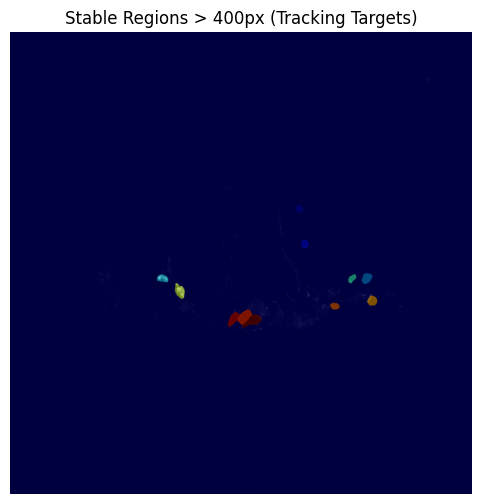

In [24]:
# Show only large regions (Area > 400 pixels) which we would actually track.

# %%
MIN_AREA = 400

# Filter masks
u_ids = np.unique(masks)
filtered_mask = np.zeros_like(masks)
count = 0

print("Stable Regions Found:")
for uid in u_ids:
    if uid == 0: continue
    
    binary = (masks == uid)
    area = np.sum(binary)
    
    if area > MIN_AREA:
        count += 1
        filtered_mask[binary] = uid
        # Calculate centroid for display
        y, x = np.where(binary)
        cy, cx = int(np.mean(y)), int(np.mean(x))
        print(f"  Region {count}: Area={area} px, Centroid=({cx}, {cy})")

# Visualize Filtered
fig = plt.figure(figsize=(6, 6))
plt.imshow(ck_vis, cmap='gray')
plt.imshow(filtered_mask, cmap='jet', alpha=0.5) # Overlay with transparency
plt.title(f"Stable Regions > {MIN_AREA}px (Tracking Targets)")
plt.axis('off')
plt.show()

### 5. Batch Run on ALL Cores (QC Generation)

In [25]:
import os
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from cellpose import plot

# --- CONFIGURATION ---
OUTPUT_QC_DIR = os.path.join(INPUT_ROOT, "Cellpose_QC_30diameter")
os.makedirs(OUTPUT_QC_DIR, exist_ok=True)

# Parameters (Ensure these match what you tuned above)
BATCH_DIAMETER = 60
BATCH_FLOW_THRESH = 0.4
CK_INDEX = 6 

print(f"Starting Batch QC Run...")
print(f"Results will be saved to: {OUTPUT_QC_DIR}")

# Find all core folders
core_folders = sorted(glob(os.path.join(INPUT_ROOT, "Core*")))

for core_folder in tqdm(core_folders):
    core_id = os.path.basename(core_folder)
    
    # 1. Find Middle Slice
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: continue
    
    mid_idx = len(slice_files) // 2
    fpath = slice_files[mid_idx]
    
    try:
        # 2. Load Image
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # Normalize for Cellpose (0-1 range is often better, but it handles raw too)
        # We'll normalize for visualization consistency
        ck_vis = cv2.normalize(ck, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # 3. Run Inference
        # Note: We use the 'model' object you initialized in the previous cells
        masks, flows, styles = model.eval(
            ck, 
            diameter=BATCH_DIAMETER, 
            channels=[0,0], 
            flow_threshold=BATCH_FLOW_THRESH
        )
        
        # 4. Create Visualization
        # Create a figure with 2 subplots
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Left: Raw Image
        ax[0].imshow(ck_vis, cmap='gray')
        ax[0].set_title(f"{core_id} - Slice {mid_idx}\nRaw CK")
        ax[0].axis('off')
        
        # Right: Mask Overlay
        mask_overlay = plot.mask_overlay(ck_vis, masks)
        ax[1].imshow(mask_overlay)
        ax[1].set_title(f"Cellpose Prediction\n(Diam={BATCH_DIAMETER})")
        ax[1].axis('off')
        
        # 5. Save to Disk
        save_path = os.path.join(OUTPUT_QC_DIR, f"{core_id}_QC.jpg")
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.close(fig) # Close to free memory
        
    except Exception as e:
        print(f"Failed {core_id}: {e}")

print("Batch Run Complete. Check the 'Cellpose_QC' folder.")

Starting Batch QC Run...
Results will be saved to: /data3/junming/3D-TMA-Register/downsampled_4x/Cellpose_QC_30diameter


100%|██████████| 30/30 [05:28<00:00, 10.97s/it]

Batch Run Complete. Check the 'Cellpose_QC' folder.
